## Information theory vs P(1-P) in solving "Bulls and cows"

The game rules: https://en.wikipedia.org/wiki/Bulls_and_Cows
I chose the guest according the one which maximize -Plog(P) or P(1-P), and compare which one works better...

In [292]:
import math
import pprint
from collections import defaultdict
import random
from matplotlib import pyplot as plt

In [3]:
class CombiHelper:
    
    def __init__(self, Range, digits):
        self.R = Range
        self.D = digits
        
    def ind_to_combi(self, ind):
        
        options = range(self.R)
        l = []
        for d in range(self.D):
            i = ind % (self.R-d)
            l.append(options.pop(i))
            ind /= (self.R-d)
            
        combi = tuple(l)
        return combi
    
    def get_num_possible_combi(self):
        numPos = 1
        for d in range(self.D):
            numPos *= self.R - d
            
        return numPos
        
    def gen_all_combi(self):
        
        all_combi = []
        for ind in range(self.get_num_possible_combi()):
            all_combi.append(self.ind_to_combi(ind))
            
        return all_combi
        
    def compare_combi(self, combi1, combi2):
        
        B = 0 #buls
        H = 0 # hits
        
        s = set(combi1)
        
        for d1, d2 in zip(combi1, combi2):
            if d1 == d2:
                B += 1
            elif d2 in s:
                H += 1
        
        return (B,H)
                    
        

In [103]:
# Testing

R,D = 4, 2
cHelper = CombiHelper(R, D)

print '----------'
print 'ind_to_combi'
combi_list = [cHelper.ind_to_combi(ind) for ind in range(4)]
print combi_list

print '----------'
print 'num possibilities'
print cHelper.get_num_possible_combi() == 12

print '----------'
print 'compare combi'
cInd = [(0,0), (0,2), (2,3)]
for ind in cInd:
    c1, c2 = combi_list[ind[0]],combi_list[ind[1]]
    res = cHelper.compare_combi(c1, c2)
    print c1, c2, 'buls=%s, hits=%s' %(res[0], res[1])
    
print '----------'
print 'gen all combi'
print cHelper.gen_all_combi()


----------
ind_to_combi
[(0, 1, 2), (1, 0, 2), (2, 0, 1), (3, 0, 1)]
----------
num possibilities
False
----------
compare combi
(0, 1, 2) (0, 1, 2) buls=3, hits=0
(0, 1, 2) (2, 0, 1) buls=0, hits=3
(2, 0, 1) (3, 0, 1) buls=2, hits=0
----------
gen all combi
[(0, 1, 2), (1, 0, 2), (2, 0, 1), (3, 0, 1), (0, 2, 1), (1, 2, 0), (2, 1, 0), (3, 1, 0), (0, 3, 1), (1, 3, 0), (2, 3, 0), (3, 2, 0), (0, 1, 3), (1, 0, 3), (2, 0, 3), (3, 0, 2), (0, 2, 3), (1, 2, 3), (2, 1, 3), (3, 1, 2), (0, 3, 2), (1, 3, 2), (2, 3, 1), (3, 2, 1)]


In [193]:
class BH_Game:
    def __init__(self, combi_helper):
        self.CH = combi_helper
        self.code = None
        self.num_attempts = None
        self.game_active = False
        
    def start(self):
        self.code = self.CH.ind_to_combi(random.randint(0,self.CH.get_num_possible_combi()-1))
        self.num_attempts = 0
        self.game_active = True
        
    def guess(self, guess):
        res = self.CH.compare_combi(self.code, guess)
        if self.game_active:
            self.num_attempts += 1
        if res[0] == len(self.code):
            self.game_active = False
        return res, self.num_attempts
        
    def get_num_attempt(self):
        return self.num_attempts

In [194]:
# Testing

game = BH_Game(cHelper)
game.start()
for ind in range(8):
    guess = cHelper.ind_to_combi(ind)
    res, itt = game.guess(guess)
    print guess, 'B=%s, H=%s' %(res[0], res[1]), itt

(0, 1, 2, 3) B=0, H=1 1
(1, 0, 2, 3) B=1, H=0 2
(2, 0, 1, 3) B=1, H=0 3
(3, 0, 1, 2) B=1, H=0 4
(4, 0, 1, 2) B=1, H=0 5
(5, 0, 1, 2) B=1, H=0 6
(6, 0, 1, 2) B=1, H=1 7
(7, 0, 1, 2) B=2, H=0 8


In [282]:
class Solver:
    
    def __init__(self, combi_helper):
        self.CH = combi_helper
        self.all_combi = tuple(self.CH.gen_all_combi())
        self.posible_combis = set(self.all_combi)
        self.solved = False
        self.mode = 'information'
        
    def score_hist(self, hist):
        
        score = 0
        for k, p in hist.iteritems():
            if self.mode == 'p(1-p)':
                score += p*(1.0-p)
            elif self.mode == 'information':
                score += -p*math.log(p)
            
        return score
            
    def build_results_probabilty(self, combi):
        res_prob = defaultdict(float)

        N = len(self.posible_combis)
        dP = 1.0/N
        for pos_com in self.posible_combis:
            res = self.CH.compare_combi(pos_com, combi)
            res_prob[res] += dP
            
        return res_prob

    def select_next_guss(self,score_per_combi, hist_per_combi):
        
        nextGuess = None
        maxBullsScore = -99999999.9
        bullsEye = (self.CH.D,0)
        maxScore = max(score_per_combi.values())
        for c, s in score_per_combi.iteritems():
            combiHist = hist_per_combi[c]
            if s == maxScore and combiHist[bullsEye] > maxBullsScore:
                nextGuess = c
                maxBullsScore = combiHist[bullsEye]
        return nextGuess

    def solve(self, game, mode='information'):
        self.posible_combis = set(self.all_combi)
        self.mode = mode
        self.solved = False
        
        itt = 0
        pastGuess = set()
        while not self.solved and itt < 100 and len(self.posible_combis) > 0:
            itt += 1
            hist_per_combi = defaultdict(lambda: defaultdict(float))
            score_per_combi = {}
                
            if itt == 1:
                currGuess = random.sample(self.posible_combis, 1)[0]
            else:
                for combi in self.all_combi:
                    if combi not in pastGuess:
                        res_prob = self.build_results_probabilty(combi)
                        hist_per_combi[combi] = res_prob
                        score_per_combi[combi] = self.score_hist(res_prob)
                currGuess = self.select_next_guss(score_per_combi, hist_per_combi)
                
            pastGuess.add(currGuess)
            res, numAttempts = game.guess(currGuess)
#             print '#'+str(itt),' #Options:', len(self.posible_combis), ', Gussing:', currGuess, ', Result:', res
            
            if res == (self.CH.D,0):
                self.solved = True
                
            # removing combis that couldn't produce this reult
            imposible_combies = []
            for c in self.posible_combis:
                if res != self.CH.compare_combi(c,currGuess):
                    imposible_combies.append(c)
                    
            for c in imposible_combies:
                self.posible_combis.remove(c)
            
#         print 'Code is: ', self.posible_combis
#         print 'num guess: ', game.get_num_attempt()
        return game.get_num_attempt()

        

In [283]:
# testing
R,D = 6, 4
cHelper = CombiHelper(R, D)
solver = Solver(cHelper)
game = BH_Game(cHelper)

In [284]:
game.start()
solver.solve(game,mode='information')

5

In [331]:
num_attempts_hist = defaultdict(lambda:defaultdict(int))

R,D = 10, 4
cHelper = CombiHelper(R, D)
solver = Solver(cHelper)
game = BH_Game(cHelper)

N = 1000
for i in range(N):
    for mode in ('information', 'p(1-p)'):
        game.start()
        num_att = solver.solve(game, mode=mode)
        num_attempts_hist[mode][num_att] += 1
    

defaultdict(<function <lambda> at 0x000000000AF143C8>, {'information': defaultdict(<type 'int'>, {1: 5, 2: 12, 3: 205, 4: 541, 5: 237}), 'p(1-p)': defaultdict(<type 'int'>, {1: 3, 2: 10, 3: 167, 4: 558, 5: 259, 6: 3})})


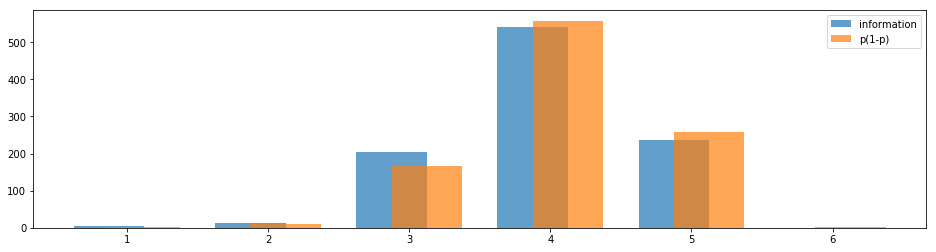

In [332]:
fig = plt.figure(figsize=(16,4))
offset = {'information':-0.125, 'p(1-p)':0.125}
for k, h in num_attempts_hist.iteritems():
    x = [xx+offset[k] for xx in h.keys()]
    plt.bar(x, h.values(), width=0.5, label=k, alpha=0.7)
    
plt.legend()
plt.show()